In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [3]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,E-commerce platform Shopify to let employees w...,"After Twitter, Canadian e-commerce website Sho...",technology
1,Half of Facebook's employees may work from hom...,Facebook will permanently allow remote work ev...,technology
2,SC seeks Centre's reply on plea for ban on Zoo...,The Supreme Court on Friday sought Centre's re...,technology
3,Sealed the deal in 10 days over Zoom calls: KK...,US-based private equity firm KKR has said it n...,technology
4,Aarogya Setu downgraded from 2 to 1 star by MI...,MIT Technology Review has downgraded Aarogya S...,technology
5,Some of my tweets were definitely extremely du...,Tesla and SpaceX CEO Elon Musk admitted that s...,technology
6,AI creates new Pac-Man version just by watchin...,"On the fortieth anniversary of Pac-Man, graphi...",technology
7,"KKR to invest $1.5 billion in Jio Platforms, i...",US private equity firm KKR will invest $1.5 bi...,technology
8,"Fastest internet speed of 44.2 Tbps recorded, ...","Researchers from Australia's Monash, Swinburne...",technology
9,TN man says Google Maps creating problems in h...,A 49-year-old man in Tamil Nadu has said he's ...,technology


In [4]:
news_df.news_category.value_counts()

world         25
sports        25
technology    24
Name: news_category, dtype: int64

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [6]:
sentiment = news_df['news_article'].apply(analyser.polarity_scores)

In [7]:
sentiment_df = pd.DataFrame(sentiment.tolist())
sentiment_df = sentiment_df.rename(columns={'compound':'sentiment_score'})
sentiment_df.head()

,sentiment_score,neg,neu,pos
0,0.2263,0.000,0.969,0.031
1,0.2732,0.037,0.893,0.070
2,-0.5719,0.122,0.825,0.053
3,0.2732,0.000,0.948,0.052
4,-0.7184,0.094,0.906,0.000


In [8]:
sentiment_df = sentiment_df.drop(columns=['pos','neg','neu'])
sentiment_category = ['positive' if compound >= 0.05 
                          else 'neutral' if (compound < 0.05) and (compound > -0.05)
                              else 'negative' 
                                  for compound in sentiment_df['sentiment_score']]
category_df = pd.DataFrame(sentiment_category,columns=['sentiment_category'])

In [9]:
df = pd.concat([news_df,sentiment_df,category_df], axis = 1)

In [10]:
df.groupby(by=['news_category']).describe()

sentiment_score                                              \
                        count      mean       std     min     25%     50%   
news_category                                                               
sports                   25.0  0.114316  0.592105 -0.8957 -0.4019  0.0000   
technology               24.0  0.122150  0.580843 -0.9001 -0.5497  0.3066   
world                    25.0 -0.173216  0.560568 -0.8934 -0.6124 -0.2075   

                               
                  75%     max  
news_category                  
sports         0.7845  0.9476  
technology     0.5169  0.9169  
world          0.2023  0.8519

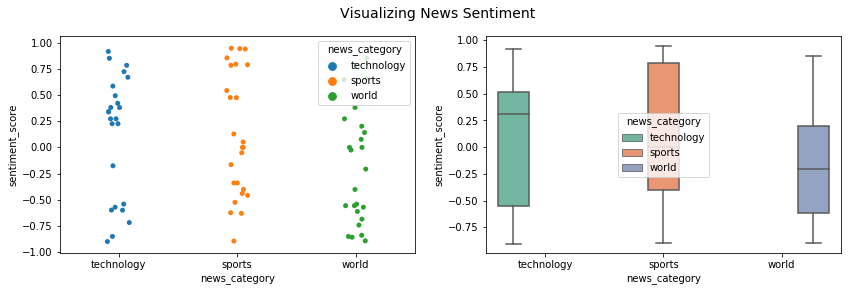

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

C:\Users\rawat\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


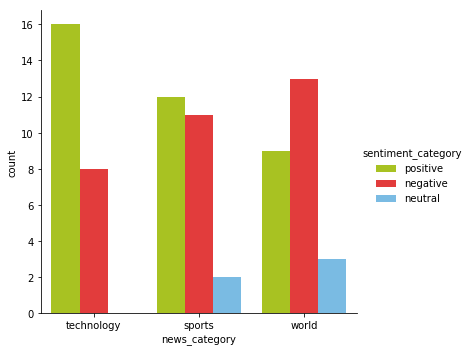

In [12]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [13]:
p_score = df[df.news_category=='technology'].sentiment_score.max();
n_score = df[df.news_category=='technology'].sentiment_score.min();
tpos_idx = df[(df.news_category=='technology') & (df.sentiment_score == p_score)].index[0]
tneg_idx = df[(df.news_category=='technology') & (df.sentiment_score == n_score)].index[0]

In [14]:
p_score = df[df.news_category=='world'].sentiment_score.max();
n_score = df[df.news_category=='world'].sentiment_score.min();
wpos_idx = df[(df.news_category=='world') & (df.sentiment_score == p_score)].index[0]
wneg_idx = df[(df.news_category=='world') & (df.sentiment_score == n_score)].index[0]

In [15]:
p_score = df[df.news_category=='sports'].sentiment_score.max();
n_score = df[df.news_category=='sports'].sentiment_score.min();
spos_idx = df[(df.news_category=='sports') & (df.sentiment_score == p_score)].index[0]
sneg_idx = df[(df.news_category=='sports') & (df.sentiment_score == n_score)].index[0]

In [16]:
fc.savefig("graph.png")

In [18]:
tn = news_df.iloc[tneg_idx][['news_headline']][0]
tp = news_df.iloc[tpos_idx][['news_headline']][0]
wn = news_df.iloc[wneg_idx][['news_headline']][0]
wp = news_df.iloc[wpos_idx][['news_headline']][0]
sn = news_df.iloc[sneg_idx][['news_headline']][0]
sp = news_df.iloc[spos_idx][['news_headline']][0]

from tkinter import *

root = Tk()

def onClick():
    text.set("Most Negative Technology News Article: "+tn+"\n"
             +"Most Positive Technology News Article: "+tp+"\n\n"
             +"Most Negative World News Article: "+wn+"\n"
             +"Most Positive World News Article: "+wp+"\n\n"
             +"Most Negative Sports News Article: "+sn+"\n"
             +"Most Positive Sports News Article: "+sp)

text = StringVar()
root.geometry("644x434")
root.title("Created By Swapnil")
root.minsize(200,100)
root.maxsize(1200,988)
l = Label(text="Sentiment Analysis",fg="blue",font=("comicsansms",19,"bold"),borderwidth=3,relief=SUNKEN)
l.pack()
b = Button(text="click me",fg="blue",command = onClick)
b.pack()
c = Canvas(bg="white",width="500",height="400")
c.pack()
out = Label(textvariable=text)
out.pack()
img = PhotoImage(file="graph.png")
c.create_image(250,200,image=img)
root.mainloop()